In [5]:
%run 4.fusion.ipynb

Aresta [-55, 2, 17, 0.3] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-85, 3.8, 30, 0.1] -> Classe 1 (Bom) (confiança 0.53)
Aresta [-35, 1.2, 5, 0.05] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-88, 9.5, 95, 0.9] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-40, 8.2, 85, 0.8] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-87, 1.5, 8, 0.15] -> Classe 1 (Bom) (confiança 0.98)
Aresta [-62, 2.8, 32, 0.28] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-58, 3.2, 28, 0.32] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-52, 2.1, 20, 0.25] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-48, 2.5, 25, 0.22] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-50, 1.8, 22, 0.28] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-75, 5.2, 65, 0.6] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-78, 4.8, 70, 0.65] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-72, 5.5, 60, 0.58] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-45, 4.5, 15, 0.7] -> Classe 1 (Bom) (confiança 0.56)
Aresta [-70, 1.9, 45, 0.2] -> Classe 1 (Bom) (confiança 0.94

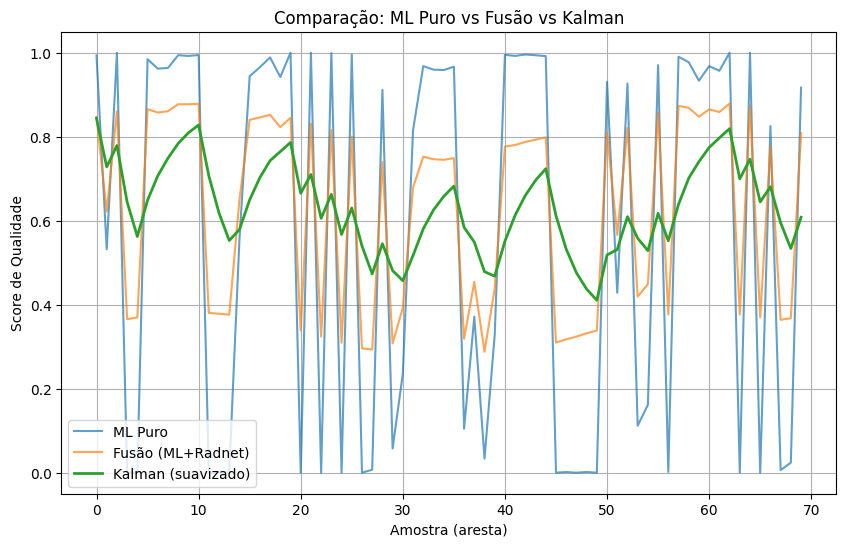

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Filtro de Kalman simples (1D) ======
class KalmanFilter1D:
    def __init__(self, process_variance=1e-3, measurement_variance=1e-2, initial_estimate=0.5):
        self.x = initial_estimate   # estimativa inicial
        self.P = 1.0                # incerteza inicial
        self.Q = process_variance   # variância do processo
        self.R = measurement_variance  # variância da medição

    def update(self, measurement):
        # Predição
        self.P += self.Q
        # Atualização
        K = self.P / (self.P + self.R)     # ganho de Kalman
        self.x += K * (measurement - self.x)
        self.P *= (1 - K)
        return self.x

# ====== Aplicar filtro em scores de fusão ======
def apply_kalman(fusion_scores):
    kf = KalmanFilter1D()
    smoothed = []
    for z in fusion_scores:
        smoothed.append(kf.update(z))
    return np.array(smoothed)

# ====== Execução ======
# fusion_scores vem do notebook de fusão
kalman_scores = apply_kalman(fusion_scores)

# ====== Plot comparando ML, Fusão e Kalman ======
plt.figure(figsize=(10,6))
plt.plot(prob_ml, label="ML Puro", alpha=0.7)
plt.plot(fusion_scores, label="Fusão (ML+Radnet)", alpha=0.7)
plt.plot(kalman_scores, label="Kalman (suavizado)", linewidth=2)
plt.xlabel("Amostra (aresta)")
plt.ylabel("Score de Qualidade")
plt.title("Comparação: ML Puro vs Fusão vs Kalman")
plt.legend()
plt.grid(True)
plt.show()
